Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
NAME = "Kanawut Kaewnoparat"
ID = "st122109"

---

# Lab 12: Gaussian Mixture Models (GMMs)

Today we continue with unsupervised learning. One model that's more sophisticated than $k$-means is the Gaussian Mixture Model (GMM).

The GMM models a dataset $(\mathbf{x}^{(1)},\ldots,\mathbf{x}^{(m)})$ as an i.i.d. sample from the following
generative model for each sample
$\mathbf{x}^{(i)}$:

1. Sample $z^{(i)}$ from a multinomial distribution over clusters $1..k$ according to probabilities $(\phi_1,\ldots,\phi_k)$.
2. Sample $\mathbf{x}^{(i)}$ from ${\cal N}(\mathbf{\mu}_{z^{(i)}},\Sigma_{z^{(i)}})$.

The parameters are estimated using the Expectation Maximization (EM) algorithm, which begins with a guess for parameters
$\phi_1,\ldots,\phi_k,\mu_1,\ldots,\mu_k,\Sigma_1,\ldots,\Sigma_k$ then iteratively alternates between computing a soft assignment
of data to clusters then updating the parameters according to that soft assignment.

First, we'll build a GMM model for a dataset then use the model for anomaly detection.

## Example 1: Anomaly detection

Let's generate synthetic data from a mixture of Gaussians, use EM to recover as best possible the ground truth parameters, and
then use the model to find "anomalies" (unusually unlikely points according to the model). First, we set up the ground truth
parameters and generate a dataset from those ground truth parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Ground truth means and covariances for the data we'll generate

means_gt = [ [1,10], [10,1], [10,10] ]
sigmas_gt = [ np.matrix([[1, 0],[0, 1]]), np.matrix([[4,0],[0,1]]),
              np.matrix([[1,0],[0,4]]) ]

# Ground truth Prior probability (phi_j) for each cluster

phi_gt = [ 0.2, 0.2, 0.6 ]

# For more interesting covariances, you can also try, for example,
# [[11.31371, -0.70711],[11.31371, 0.70711]] or
# [[11.31371, 0.70711],[-11.31371, 0.70711]].

# Size of dataset

m = 500

# number of variables

n = len(means_gt[0])

# k number of clusters/outcomes

k = len(phi_gt)

# Ground truth indices of cluster identities

Z = [0]*m

# Generate a new k-means dataset

def gen_dataset():
    X = np.zeros((m,n))
    # Generate m samples from multinomial distribution using phi_gt
    z_vectors = np.random.multinomial(1, phi_gt, size=m)  # Result: binary matrix of size (m x k)
    for i in range(m):
        # Convert one-hot representation z_vectors[i,:] to an index
        Z[i] = np.where(z_vectors[i,:] == 1)[0][0]
        # Grab ground truth mean mu_{z^i}
        mu = means_gt[Z[i]]                
        # Grab ground truth covariance Sigma_{z^i}
        sigma = sigmas_gt[Z[i]]
        # Sample a 2D point from mu, sigma
        X[i,:] = np.random.multivariate_normal(mu,sigma,1)
    return X


X = gen_dataset()

In [3]:
X[:5, :]

array([[10.02329152, 10.31863531],
       [ 1.17779384,  9.30728395],
       [ 9.1820048 , 11.85202421],
       [10.7602968 , 11.14618254],
       [ 9.66242356,  9.27237753]])

Next, the EM algorithm itself. We have an initialization step and an iterative step.

In [4]:
def init_gmm(X, k):
    m = X.shape[0]
    n = X.shape[1]
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        # Initially assign equal probability to each cluster/outcome
        Phi[j] = 1/k      
        # Ramdomly assign mean to one of the data points       
        Mu[:,j] = X[order[j],:].T
        # Initial covariance is identity matrix
        Sigma[j,:,:] = np.eye(n)    
    return Phi, Mu, Sigma


def Gaussian(X, mean, covariance):
    k = len(mean)
    X = X - mean.T
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * np.sum(X @ np.linalg.pinv(covariance) * X, axis=1))
    return p

def gaussian(x, mean,covariance):
    k = len(mean)
    X = (x - mean).reshape(-1,1)
    p = 1/((2*np.pi)**(k/2)*(np.linalg.det(covariance)**0.5)) * np.exp(-0.5 * (X.T @ np.linalg.pinv(covariance) @ X))
    return p


# Run one iteration of EM

def iterate_em_gmm(X, threshold, Phi, Mu, Sigma):
    m = X.shape[0]
    n = X.shape[1]
    k = len(Phi)
    threshold = np.reshape(np.repeat(threshold, n*k), (n,k))
    pj_arr = np.zeros((m,k))
    
    # E-step: calculate w_j^i
    W = np.zeros((m, k))
    for j in range(k):
        pj = Gaussian(X, Mu[:,j], Sigma[j])
        pj_arr[:,j] = pj
        W[:,j] = Phi[j] * pj
    
    # W tells us what is the relative weight of each cluster for each data point
    W[:,:] = W * np.tile(1/np.sum(W,1),(k,1)).T

    # M-step: adjust mean and sigma
    Phi[:] = sum(W) / m
    Mu_previous = Mu.copy()
    for j in range(k):
        # Split cluster specific W for each dimension
        Wj = np.tile(W[:,j],(2,1)).T
        # Compute Mu for each variable for each cluster
        Mu[:,j] = sum(X * Wj)/sum(Wj)
        Muj = np.tile(Mu[:,j],(m,1))
        Sigma[j,:,:] = np.matmul((X - Muj).T, (X - Muj) * Wj) / sum(W[:,j])

    if (abs(Mu-Mu_previous) <= threshold).all():
        converged = True
    else:
        converged = False

    labels = np.argmax(pj_arr, axis = 1)
    pj = np.max(pj_arr,axis=1)
    X_label = np.insert(X, 2, labels, axis=1)
    return converged, pj, X_label

Let's run the model to convergence:

In [5]:
threshold = np.matrix(.01)

Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [6]:
print(Phi)
print(phi_gt)

phi_gt = np.array(phi_gt).reshape(-1,1)
phi_mse = np.mean(np.min((Phi-phi_gt)**2,axis=1))

print(f'phi diff: {phi_mse}')

[0.18616183 0.19400001 0.61983816]
[0.2, 0.2, 0.6]
phi diff: 0.0001551840882700895


In [7]:
print(Mu)
print(np.array(means_gt).T)

[[10.01323825  0.90119806  9.98131784]
 [ 0.89630266 10.06965857 10.0868168 ]]
[[ 1 10 10]
 [10  1 10]]


In [8]:
print(Sigma)
print(sigmas_gt)

[[[ 4.39430947 -0.1606411 ]
  [-0.1606411   1.02987224]]

 [[ 1.25668419  0.20274177]
  [ 0.20274177  1.0100161 ]]

 [[ 0.9894055  -0.04876691]
  [-0.04876691  4.2194909 ]]]
[matrix([[1, 0],
        [0, 1]]), matrix([[4, 0],
        [0, 1]]), matrix([[1, 0],
        [0, 4]])]


### In-class exercise (not graded, for practice)

Determine how close the estimated parmeters Phi, Mu, and Sigma are to the ground trouth values set up at the beginning of the experiment. Report your results and briefly discuss here.

Next, we continue to find outliers:

In [9]:
for i in range(k):
    mean_distance = [0]*k
    covariance_distance = [0]*k
    for j in range(k):
        mean_distance[j] = np.linalg.norm(Mu[:,j] - np.matrix(means_gt[i]))
        covariance_distance[j] = np.linalg.norm(Sigma[j] - sigmas_gt[i])
    min_j = np.argmin(mean_distance)
    phi_distance = np.abs(Phi[min_j] - phi_gt[i])
    print('\nMu Distance : {}'.format(mean_distance[min_j]))
    print('Covariance Distance : {}'.format(covariance_distance[min_j]))
    print('Phi Distance : {}'.format(phi_distance))


Mu Distance : 0.12088895935623112
Covariance Distance : 0.38496174151329143
Phi Distance : [0.00599999]

Mu Distance : 0.10453893614959227
Covariance Distance : 0.45605200926071765
Phi Distance : [0.01383817]

Mu Distance : 0.08880416438099561
Covariance Distance : 0.23031482947455473
Phi Distance : [0.01983816]


In [10]:
outlier_prob = .01
outliers = np.nonzero(pj < outlier_prob)[0]

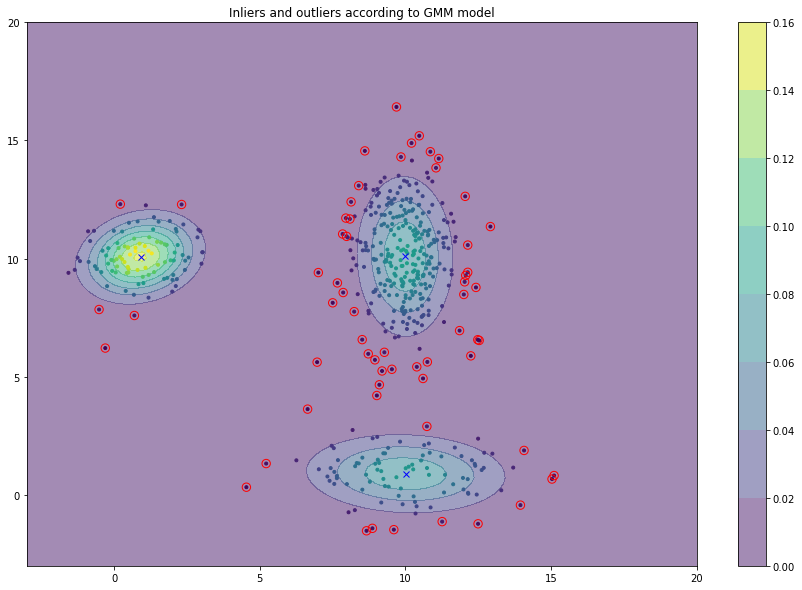

In [11]:
fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
cbar = fig1.colorbar(cp)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()

### In-class exercise

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a
tight cluster. First, you'll want to understand why and explain.  Next, you'll read about
Mahalanobis distance
of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance
to get a better notion of outliers in this dataset.

### Exercise 1.1 (10 points)

Notice that using a hard threshold for each cluster gives us more outliers for a broad cluster than a tight cluster. Understand why, and explain here.

From the Z-score test, high variane dataset will flatten and lower the normal curve, therefore, will have a lower threshold for a particular p value compared to a low variance distribution. 

As a consequent, broader clusters with higher variance will have more outliers when using the same threshold value from tight clusters.
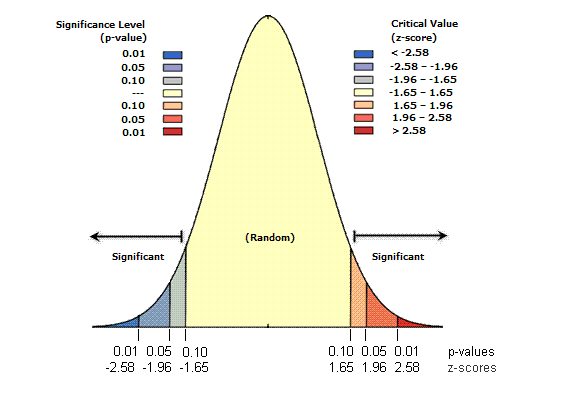


We can summarize in human words: if the data is more spread out (high variance), we can say with less confidence (lower threshold) that the data points belongs to the distribution.

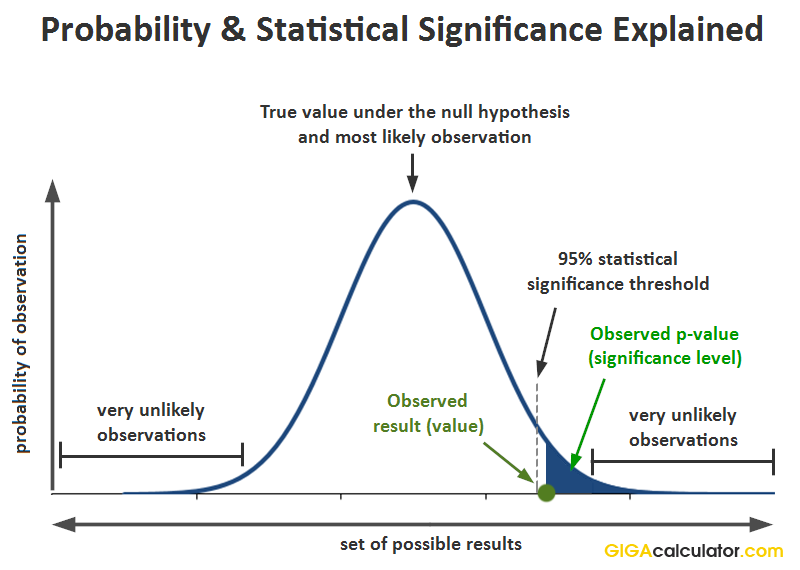

### Exercise 1.2 (15 points)

Read about Mahalanobis distance of a point to the mean of a multivariate Gaussian distribution and see if you can use Mahalanobis distance to get a better notion of outliers in this dataset.
1. Explain what is Mahalanobis (5 points)
2. Write code Mahalanobis (10 points)

#### Explain what is Mahalanobis distance (5 points)

`Mahalanobis distance` is a distance between a point and a distribution. It is more effective that euclidean distances as it scales the data by covariance to transfrom each columns or featues into uncorrelated variables. As a result, the distance computed with Mahalanobis is better at detecting outliers as all the data points are now normalized and split into uncorrelated features.

The basic computational steps are as follows:
1) It transforms the columns into uncorrelated variables
2) Scale the columns to make their variance equal to 1
3) Finally, it calculates the Euclidean distance.



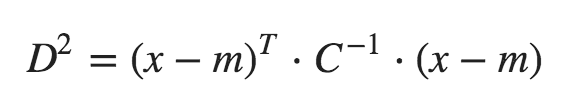

where, 
 - D$^2$        is the square of the Mahalanobis distance. 
 - x          is the vector of the observation (row in a dataset), 
 - m          is the vector of mean values of independent variables (mean of each column), 
 - C$^{-1}$    is the inverse covariance matrix of independent variables.

#### Write code to compute Mahalanobis distance between the data and their nearest means (10 points)

In [12]:
X.shape

(500, 2)

In [13]:
Mu.shape

(2, 3)

(3, 2, 2)
(2, 3)
(500, 2)
outlier (array([  5,   7,  14,  24,  42,  60,  82,  87,  92, 130, 138, 154, 158,
       167, 187, 188, 196, 204, 206, 208, 214, 233, 250, 275, 283, 287,
       290, 295, 303, 305, 307, 314, 315, 318, 326, 344, 346, 356, 361,
       381, 386, 389, 399, 419, 420, 432, 435, 440, 441, 443, 445, 455,
       463, 465, 468, 476, 484, 494, 495, 498]),)


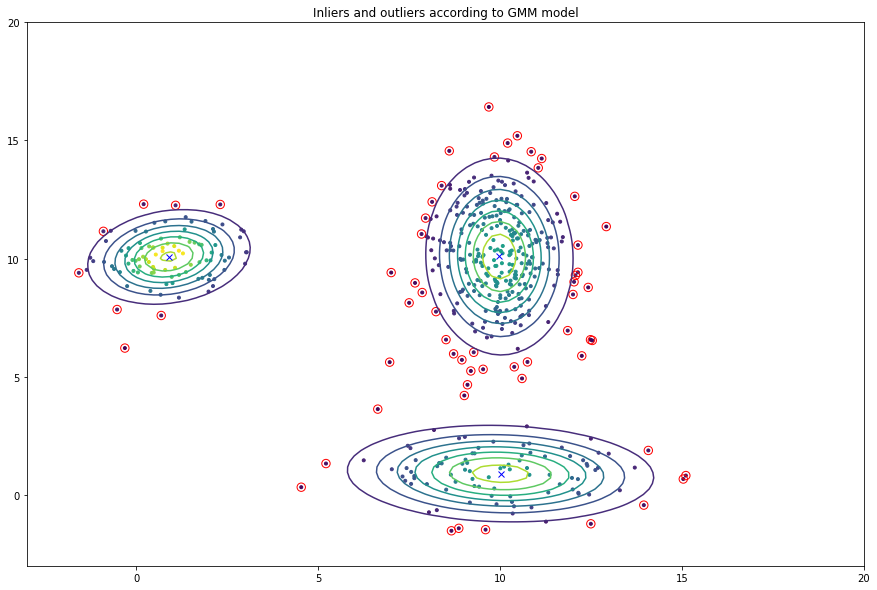

success!


In [14]:
import sys
#np.set_printoptions(threshold=sys.maxsize)

print(Sigma.shape)
print(Mu.shape)
print(X.shape)


##Mahalanobis distance
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:, kk]
        # get target sigma
        sig = Sigma[kk, : ,: ].reshape((n,n))
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(n,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

# find unique of minimum m_distance and count
# hint: use np.unique and np.argmin
(unique, counts) = None, None

max_z_score = 2.05
# find minimum distance
# hint: use np.min
min_distance = np.min(m_distance, axis = 1)
# find outlier from min_distance
outlier = np.where( min_distance >max_z_score)
# YOUR CODE HERE
# raise NotImplementedError()

# Test function: Do not remove
print('outlier', outlier)

fig1 = plt.figure(figsize=(15,10))

xlist = np.linspace(-3, 20, 100)
ylist = np.linspace(-3, 20, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])[0]
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX,YY,Z)

plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');
plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

plt.title('Inliers and outliers according to GMM model')
plt.show()
print('success!')
# End test function

## Example 2: Customer segmentation

In this example we will use the Kaggle customer segmentation dataset
from last week. We've included the
[Mall_Customers.csv](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python)
file with this lab.

Let's stick to just two dimensions in the dataset:

In [15]:
data = pd.read_csv('Mall_Customers.csv')
data = data.drop(['CustomerID', 'Gender', 'Age'], axis = 1)
print(data.head())

   Annual Income (k$)  Spending Score (1-100)
0                  15                      39
1                  15                      81
2                  16                       6
3                  16                      77
4                  17                      40


In [16]:
X  = np.array(data, dtype=float)

n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

converged = False
while not converged:
    converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [17]:
print(Mu)

[[51.13781586 60.67483105 85.65637502]
 [53.82476491 19.18929024 82.10928242]]


The first row represents annual income, whereas the second row represents the spending score. These values tend to change in every iteration, so therefore it is difficult to definitively segregate the data into three categories.

In [18]:
print(Sigma.shape)
print(Mu.shape)

(3, 2, 2)
(2, 3)


Next, the visualization:

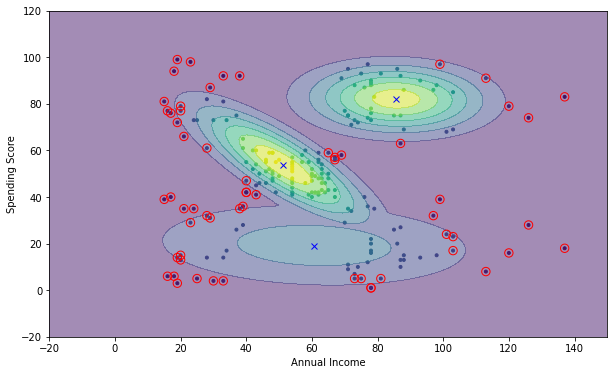

Number of outliers with GMM and euclidean distance: 60


In [19]:
plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

outlier_prob = .0002
outliers = np.nonzero(pj<outlier_prob)[0]


xlist = np.linspace(-20, 150, 100)
ylist = np.linspace(-20, 120, 100)
XX, YY = np.meshgrid(xlist, ylist)
ZZ = np.zeros(XX.shape)
for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    ZZ = np.maximum(ZZ,Z)
cp = plt.contourf(XX, YY, ZZ,alpha=0.5)
plt.scatter(X[outliers,0],X[outliers,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')
plt.xlabel('Annual Income')
plt.ylabel('Spending Score')

plt.show()

print(f'Number of outliers with GMM and euclidean distance: {len(outliers)}')

### In-class exercise (25 points)

Examine the cluster centers and determine whether you can find any reasonable interpretation of them.
Discuss in your report (5 points), and compare to the $k$-means method from last week. (20 points)

#### Interpretation of clusters (5 points)

As each time I refresh the kernel, the result would be different.
The following summary based on this specific output

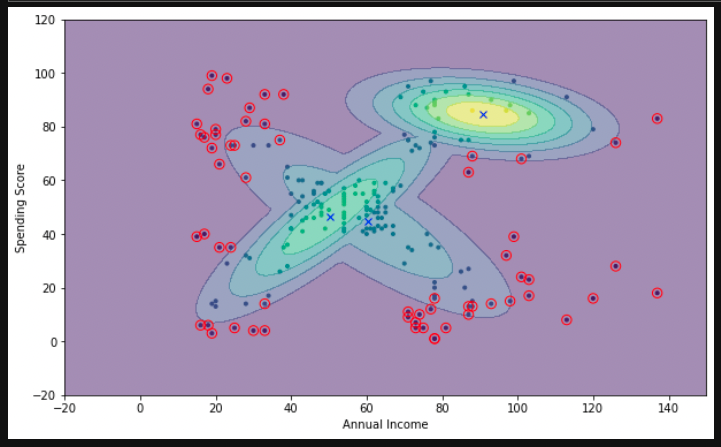


So basically, from the visualization above, we have 3 clusters wiht some interpretation as follows:
- Cluster1 (low to medium income, with posive correlation of spending score) : the more they earn, the more they pay and recieve more spending score
- Cluster2 (low to medium income, with negative correlation of spending score) : This cluster is the opposite from the first cluster. Though having the same annual income and spending score range, the result is in the reverse, meaning the less customers earn, the more spending and score they have
- cluster3 (medium to hihgh income with high spending score): This cluster refers to top spenders with high income who also spend a lot. 

Looking at the distribution of the data, we can see the normal distribution on the cluster 3 while there are lots of outliers scattering in clusters 1 and 2

#### Run $k$-means and compare results

In [20]:
def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

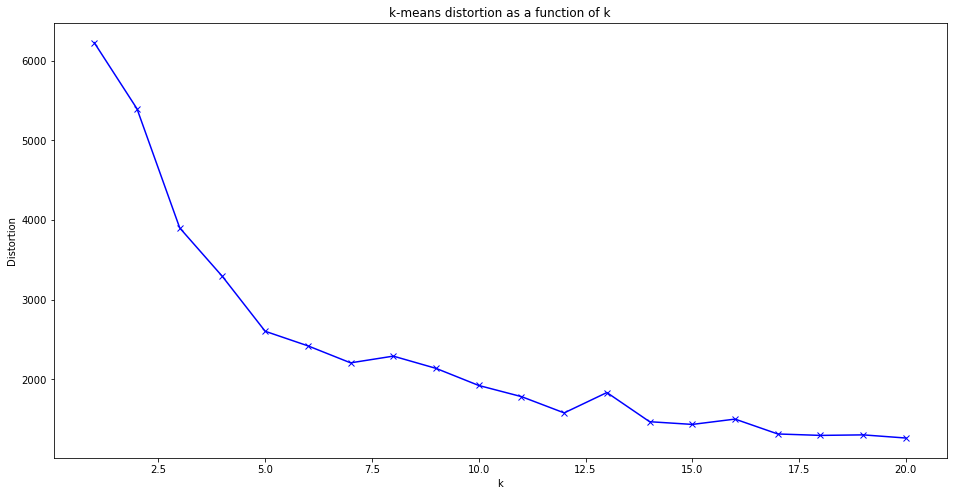

In [21]:

# Intialize hyperparameters

max_k = 20
epsilon = 0.001

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    means = init_kmeans(X, k)
    prev_distortion = 0
    while True:
        means, c, distortion = iterate_kmeans(X, means)
        if prev_distortion > 0 and prev_distortion - distortion < epsilon:
            break
        prev_distortion = distortion
    distortions[k-1] = distortion

# Plot distortion as function of k

plt.figure(figsize=(16,8))
plt.plot(range(1,max_k+1), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

In [22]:
k = 3
means = init_kmeans(X, k)
prev_distortion = 0
while True:
    means, c, distortion = iterate_kmeans(X, means)
    if prev_distortion > 0 and prev_distortion - distortion < epsilon:
        break
    prev_distortion = distortion

In [23]:
newX = np.hstack((X, c.reshape(200,1)))

In [24]:
means

array([[36.27027027, 74.37837838],
       [73.99253731, 48.8358209 ],
       [29.48275862, 25.65517241]])

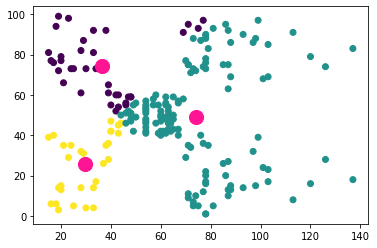

In [25]:
plt.scatter(newX[: , 0], newX[:, 1], c = newX[: , -1])
plt.scatter(means[: , 0] , means[:,1], c= 'deeppink', s = 200)

Using the normal Kmeans clustering, we see a total differernt clustering where no clusters are overlapping each other

### In-class exercise (10 points)

Do the same analysis with Mahalanobis distance as in the first example.

In [26]:
##Mahalanobis distance
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:, kk]
        # get target sigma
        sig = Sigma[kk, : ,: ].reshape((n,n))
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(n,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

In [27]:
max_z_score = 2.05
min_distance = np.min(m_distance, axis = 1)

outlier = np.where( min_distance >max_z_score)

print('outlier', outlier)
print(f'Number of outliers with GMM and euclidean distance: {len(outlier[0])}')

outlier (array([  1,   3,   5,   7,   9,  11,  17,  19,  29,  33,  41, 122, 184,
       196, 197, 198, 199]),)
Number of outliers with GMM and euclidean distance: 17


outlier (array([  1,   3,   5,   7,   9,  11,  17,  19,  29,  33,  41, 122, 184,
       196, 197, 198, 199]),)


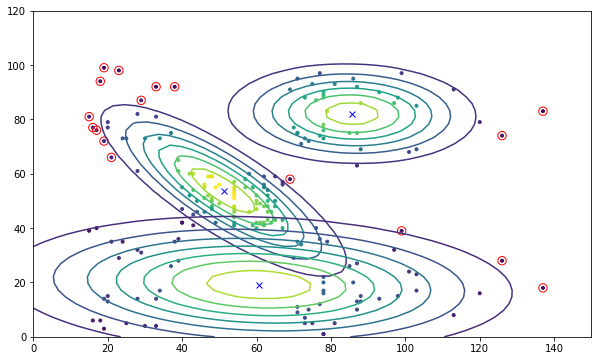

success!


In [28]:
# Test function: Do not remove
print('outlier', outlier)

plt.figure(figsize=(10,6))
plt.scatter(X[:,0],X[:,1],marker=".",c=pj,cmap='viridis');

plt.scatter(X[outlier,0],X[outlier,1],marker="o",facecolor="none",edgecolor="r",s=70);
plt.plot(Mu[0,0], Mu[1,0],'bx',Mu[0,1], Mu[1,1],'bx', Mu[0,2], Mu[1,2],'bx')

for c in np.arange(0,k):    
    X_class = X[np.where(X_label[:,2] == c)[0],:]
    xlist = np.linspace(0, 150, 50)
    ylist = np.linspace(0, 120, 50)
    
    XX, YY = np.meshgrid(xlist, ylist)
    Z = np.zeros(XX.shape)
    i = 0
    while i < XX.shape[0]:
        j = 0
        while j < XX.shape[0]:
            pt = np.array([[XX[i,j], YY[i,j]]])
            Z[i,j] = Gaussian(pt, Mu[:,c], Sigma[c])
            j = j + 1
        i = i + 1    
    cp = plt.contour(XX, YY, Z)

plt.show()
print('success!')
# End test function

## Interpreting the result of example2 customer segmentation
- GMM model with euclideant distance has outlier of 60 points
- GMM model with Mahalanobis distance has outlier of 19 points

### Example 3: Customer segmentation

This example is based on [Nguyen Hanh's tutorial on Medium.com](https://medium.com/@nguyenbaha/buiding-customer-segmentation-by-gmm-from-scratch-4ea6adc3da1c). In this example we use the Kaggle [OnlineRetail.csv](https://www.kaggle.com/vijayuv/onlineretail) dataset for customer segmentation. 

In [29]:
data = pd.read_csv('Online_Retail.csv')
data = data.iloc[0:5000,:]
print(data.head())
data = data.drop(['InvoiceNo','Description', 'CustomerID'], axis = 1)

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  InvoiceDate  UnitPrice CustomerID         Country  TotalSum  
0   12/1/2010       2.55      17850  United Kingdom     15.30  
1   12/1/2010       3.39      17850  United Kingdom     20.34  
2   12/1/2010       2.75      17850  United Kingdom     22.00  
3   12/1/2010       3.39      17850  United Kingdom     20.34  
4   12/1/2010       3.39      17850  United Kingdom     20.34  


In [30]:
print(data.dtypes)

StockCode       object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
Country         object
TotalSum       float64
dtype: object


Let's view the categorical and numeric columns:

In [31]:
categorical_colmns = data.select_dtypes(include=['object']).columns
print(categorical_colmns)
numerical_colmns = data._get_numeric_data().columns
print(numerical_colmns)

Index(['StockCode', 'InvoiceDate', 'Country'], dtype='object')
Index(['Quantity', 'UnitPrice', 'TotalSum'], dtype='object')


In [32]:
def missing_percentage(data):
    """This function takes a DataFrame(df) as input and returns two columns, 
     total missing values and total missing values percentage"""
    total = data.isnull().sum().sort_values(ascending = False)
    percent = round(data.isnull().sum().sort_values(ascending = False)/len(data)*100,2)
    return pd.concat([total, percent], axis=1, keys=['Total','Percent'])


missing_percentage(data)



,Total,Percent
TotalSum,48,0.96
Country,12,0.24
StockCode,0,0.00
Quantity,0,0.00
InvoiceDate,0,0.00
UnitPrice,0,0.00


Next, let's fill the "na" values with "No information" and 0

In [33]:
data[categorical_colmns] = data[categorical_colmns].fillna("No information")
data[numerical_colmns] = data[numerical_colmns].fillna(0)

print(data.head())

  StockCode  Quantity InvoiceDate  UnitPrice         Country  TotalSum
0    85123A         6   12/1/2010       2.55  United Kingdom     15.30
1     71053         6   12/1/2010       3.39  United Kingdom     20.34
2    84406B         8   12/1/2010       2.75  United Kingdom     22.00
3    84029G         6   12/1/2010       3.39  United Kingdom     20.34
4    84029E         6   12/1/2010       3.39  United Kingdom     20.34


Now let's convert the categorical columns to numeric. Give some thought as to whether it's appropriate
to do so for all of the columns.

In [34]:
def category_to_numeric(categorical_columns):
    i = 0;
    columnname = '';
    while i < len(categorical_colmns):
        col_idx = data.columns.get_loc(categorical_colmns[i])
        distinct_values = data[categorical_colmns[i]].unique()
        j = 0;    
        for val in distinct_values:
            idx = np.where(data[categorical_colmns[i]] == val);
            data.iloc[idx[0],col_idx] = j            
            j = j + 1;
        i = i + 1;
        
        
category_to_numeric(data[categorical_colmns])

data = data.astype('float64')
print(data.head())

   StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
0        0.0       6.0          0.0       2.55      0.0     15.30
1        1.0       6.0          0.0       3.39      0.0     20.34
2        2.0       8.0          0.0       2.75      0.0     22.00
3        3.0       6.0          0.0       3.39      0.0     20.34
4        4.0       6.0          0.0       3.39      0.0     20.34


In [35]:
Mu = np.mean(data[numerical_colmns])
Sigma = np.std(data[numerical_colmns])
print(Mu)
print(Sigma)

Quantity     10.941200
UnitPrice     3.252928
TotalSum     22.146162
dtype: float64
Quantity     146.544560
UnitPrice      5.908027
TotalSum      65.901813
dtype: float64


In [36]:
# Check for outliers

def cnt_outlier(data, sigma, mu, inc_cols=[]):
    num_cols = data.select_dtypes(include=[np.number]).columns
    num_cols = [e for e in num_cols if e in inc_cols]
    outlier = (data[numerical_colmns]-mu).abs() > sigma*3
    return outlier.sum()

cnt_outlier(data, Sigma, Mu, numerical_colmns).sort_values(ascending=False)

TotalSum     55
UnitPrice    20
Quantity      8
dtype: int64

In [37]:
if len(data[data.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(data[data.duplicated()]))
    print(data[data.duplicated(keep=False)].sort_values(by=list(data.columns)).head())
    data.drop_duplicates(inplace=True)
else:
    print("No duplicated entries found")

No. of duplicated entries:  987
      StockCode  Quantity  InvoiceDate  UnitPrice  Country  TotalSum
4099        0.0       2.0          2.0       2.95      0.0       5.9
4131        0.0       2.0          2.0       2.95      0.0       5.9
4190        0.0       2.0          2.0       2.95      0.0       5.9
0           0.0       6.0          0.0       2.55      0.0      15.3
49          0.0       6.0          0.0       2.55      0.0      15.3


## In-class and take-home exercise

Use the same GMM code as in the previous two examples on this dataset. Try to interepret the
results you get and plot the inliers/outliers with a Mahalanobis distance
threshold. Plot likelihood as a function of $k$ and determine whether there is an "elbow"
in the plot. How many clusters should you use? Describe your experiments and results in your report.

In [38]:
X = data.values

mean = np.mean(X,axis=0)
std = np.std(X,axis=0)

X = (X-mean)/std

print(X)

[[-1.3238868  -0.03572409 -1.0726451  -0.11163787 -0.26564736 -0.11949508]
 [-1.32140824 -0.03572409 -1.0726451   0.02039671 -0.26564736 -0.05026551]
 [-1.31892968 -0.02348829 -1.0726451  -0.08020106 -0.26564736 -0.0274637 ]
 ...
 [-0.60510319  0.66171654  1.5196613  -0.44643984  6.87883167  0.36263946]
 [-1.15038731  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]
 [-0.28784697  0.22122772  1.5196613  -0.42600592  6.87883167  0.03297482]]


In [39]:
n = X.shape[1]
m = X.shape[0]
k = 3

threshold = np.matrix(.01)

# Slightly different version of init_gmm due to the data format and spread
def init_gmm(X, k):
    Mu = np.zeros((n,k))
    Sigma = np.zeros((k,n,n))
    Phi = np.zeros(k)
    order = np.random.permutation(m)
    for j in range(k):
        Phi[j] = 1/k
        Mu[:,j] = X[order[j],:].T
        Sigma[j,:,:] = np.cov(X.T)
    return Phi, Mu, Sigma


Phi, Mu, Sigma = init_gmm(X, k)

# converged = False
# while not converged:
#     converged, pj, X_label = iterate_em_gmm(X, threshold, Phi, Mu, Sigma)

In [40]:
m_distance = np.zeros((X.shape[0],Mu.shape[1]))

for kk in range(Mu.shape[1]):
    for i, x in enumerate(X):
        # get all row data from target column
        mu = Mu[:, kk]
        # get target sigma
        sig = Sigma[kk, : ,: ].reshape((n,n))
        # inverse matrix of sigma
        sig_inv = np.linalg.inv(sig)
        # find difference of mu and x and reshape it (if need)
        diff = (x - mu).reshape(n,1)
        # calculate distance from diff and sigma
        distance = np.sqrt(diff.T @ sig_inv @ diff)
        # YOUR CODE HERE
        # raise NotImplementedError()
        # keep distance
        m_distance[i,kk] = distance

In [41]:
max_z_score = 2.05
min_distance = np.min(m_distance, axis = 1)

outlier = np.where( min_distance >max_z_score)

# print('outlier', outlier)
print(f'Number of outliers with GMM and euclidean distance: {len(outlier[0])}')

Number of outliers with GMM and euclidean distance: 1148


In [42]:
from scipy.stats import multivariate_normal
import math

In [43]:
r = np.full(shape=(m, 3), fill_value=1/3)



In [44]:
multivariate_normal.pdf(X[i])

array([3.82752592e-01, 3.89298302e-01, 1.25729340e-01, 3.64335893e-01,
       2.11770912e-11, 3.98725447e-01])

In [45]:
def init_kmeans(X, k):
    m = X.shape[0]
    n = X.shape[1]
    means = np.zeros((k,n))
    order = np.random.permutation(m)[:k]
    for i in range(k):
        means[i,:] = X[order[i],:]
    return means

# Run one iteration of k-means

def iterate_kmeans(X, means):
    m = X.shape[0]
    n = X.shape[1]
    k = means.shape[0]
    distortion = np.zeros(m)
    c = np.zeros(m)
    for i in range(m):
        min_j = 0
        min_dist = 0
        for j in range(k):
            dist_j = np.linalg.norm(X[i,:] - means[j,:])
            if dist_j < min_dist or j == 0:
                min_dist = dist_j
                min_j = j
        distortion[i] = min_dist
        c[i] = min_j
    for j in range(k):
        means[j,:] = np.zeros((1,n))
        nj = 0
        for i in range(m):
            if c[i] == j:
                nj = nj + 1
                means[j,:] = means[j,:] + X[i,:]
        if nj > 0:
            means[j,:] = means[j,:] / nj
    return means, c, np.sum(distortion)

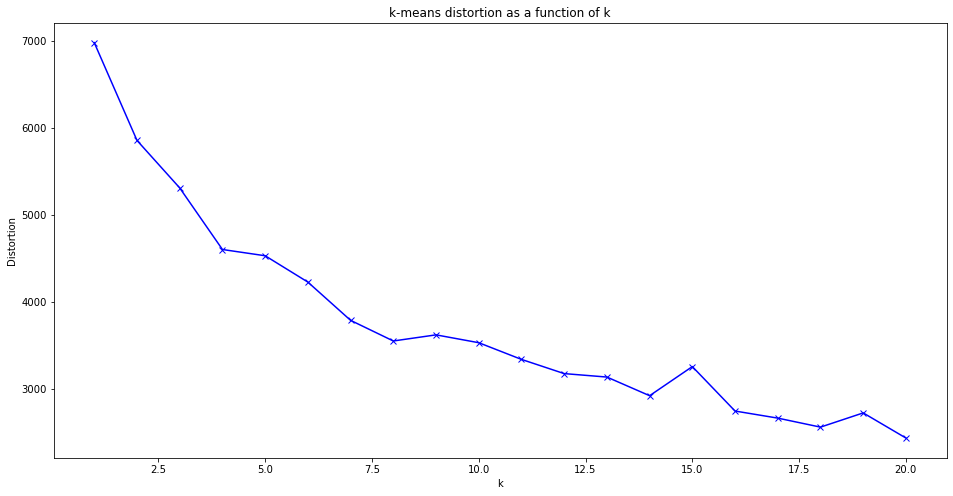

In [46]:

# Intialize hyperparameters

max_k = 20
epsilon = 0.001

# For each value of k, do one run and record the resulting cost (Euclidean distortion)

distortions = np.zeros(max_k)
for k in range(1, max_k + 1):
    means = init_kmeans(X, k)
    prev_distortion = 0
    while True:
        means, c, distortion = iterate_kmeans(X, means)
        if prev_distortion > 0 and prev_distortion - distortion < epsilon:
            break
        prev_distortion = distortion
    distortions[k-1] = distortion

# Plot distortion as function of k

plt.figure(figsize=(16,8))
plt.plot(range(1,max_k+1), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('k-means distortion as a function of k')
plt.show()

looking at the elbow plot, the model should have 3 clusters

---